In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import joblib


import warnings
warnings.filterwarnings('ignore')

2023-06-21 08:43:48.805350: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 08:43:49.056697: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 08:43:49.058098: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 08:43:50.081703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
failures_data = pd.read_csv("data/failures.csv")
machines_data = pd.read_csv("data/machines.csv")
telemetry_data = pd.read_csv("data/telemetry.csv")

Telemetry Dataset

In [3]:
failures_data.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
machines_data.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [10]:
telemetry_data.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [3]:
# Merge failures and machines dataframes on machineID
failures_machines = pd.merge(failures_data, machines_data, on='machineID', how='left')

In [4]:
failures_machines

,datetime,machineID,failure,model,age
0,2015-01-05 06:00:00,1,comp4,model3,18
1,2015-03-06 06:00:00,1,comp1,model3,18
2,2015-04-20 06:00:00,1,comp2,model3,18
3,2015-06-19 06:00:00,1,comp4,model3,18
4,2015-09-02 06:00:00,1,comp4,model3,18
...,...,...,...,...,...
756,2015-11-29 06:00:00,99,comp3,model1,14
757,2015-12-14 06:00:00,99,comp4,model1,14
758,2015-02-12 06:00:00,100,comp1,model4,5
759,2015-09-10 06:00:00,100,comp1,model4,5


In [5]:
# Merge failures_machines and telemetry dataframes on machineID and datetime
merged_df = pd.merge(failures_machines, telemetry_data, on=['machineID', 'datetime'], how='left')

In [6]:
merged_df

,datetime,machineID,failure,model,age,volt,rotate,pressure,vibration
0,2015-01-05 06:00:00,1,comp4,model3,18,179.303153,499.777962,111.833028,52.383097
1,2015-03-06 06:00:00,1,comp1,model3,18,198.257975,456.862342,89.333995,38.671900
2,2015-04-20 06:00:00,1,comp2,model3,18,180.050801,346.362480,105.661164,39.218055
3,2015-06-19 06:00:00,1,comp4,model3,18,187.673963,493.005160,105.334392,53.963961
4,2015-09-02 06:00:00,1,comp4,model3,18,144.094532,409.380150,106.720871,57.454990
...,...,...,...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,comp3,model1,14,205.336154,398.728678,116.164197,35.588661
757,2015-12-14 06:00:00,99,comp4,model1,14,152.143212,394.182739,114.212265,40.852043
758,2015-02-12 06:00:00,100,comp1,model4,5,226.666914,484.516473,97.521897,53.129437
759,2015-09-10 06:00:00,100,comp1,model4,5,201.781023,520.820195,90.944571,39.066892


In [7]:
# Move the failure column to the end of the dataframe
failure_column = merged_df.pop('failure')
merged_df['failure'] = failure_column

In [8]:
# Print the merged dataframe
merged_df.head()

,datetime,machineID,model,age,volt,rotate,pressure,vibration,failure
0,2015-01-05 06:00:00,1,model3,18,179.303153,499.777962,111.833028,52.383097,comp4
1,2015-03-06 06:00:00,1,model3,18,198.257975,456.862342,89.333995,38.671900,comp1
2,2015-04-20 06:00:00,1,model3,18,180.050801,346.362480,105.661164,39.218055,comp2
3,2015-06-19 06:00:00,1,model3,18,187.673963,493.005160,105.334392,53.963961,comp4
4,2015-09-02 06:00:00,1,model3,18,144.094532,409.380150,106.720871,57.454990,comp4


In [10]:
merged_df.failure.describe()

count       761
unique        4
top       comp2
freq        259
Name: failure, dtype: object

In [18]:
merged_df.failure.info()

<class 'pandas.core.series.Series'>
RangeIndex: 761 entries, 0 to 760
Series name: failure
Non-Null Count  Dtype 
--------------  ----- 
761 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [11]:
#COMP0 HATASIZ ÇALIŞANLAR, DİĞERLERİ HATA KODLARI
print("Comp0: ", merged_df[merged_df.failure == "comp0"].shape[0])
print("Comp1: ", merged_df[merged_df.failure == "comp1"].shape[0])
print("Comp2: ", merged_df[merged_df.failure == "comp2"].shape[0])
print("Comp3: ", merged_df[merged_df.failure == "comp3"].shape[0])
print("Comp4: ", merged_df[merged_df.failure == "comp4"].shape[0])

Comp0:  0
Comp1:  192
Comp2:  259
Comp3:  131
Comp4:  179


In [12]:
telemetry_data

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511
...,...,...,...,...,...,...
876095,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941
876096,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072
876097,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561
876098,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259


In [9]:
#DATANIN OLUŞTURULMASI
data = telemetry_data.merge(failures_data, how="left", on=["datetime", "machineID"], copy=False)
data.insert(1, "age", [machines_data["age"][i-1] for i in data.machineID])
data.iloc[:,-1][data.failure.isna()] = "comp0"
data_2 = data[data.machineID >= 80]
data = data[data.machineID < 80 ]
#COMP0 HATASIZ ÇALIŞANLAR, DİĞERLERİ HATA KODLARI
print("Comp0: ", data[data.failure == "comp0"].shape[0])
print("Comp1: ", data[data.failure == "comp1"].shape[0])
print("Comp2: ", data[data.failure == "comp2"].shape[0])
print("Comp3: ", data[data.failure == "comp3"].shape[0])
print("Comp4: ", data[data.failure == "comp4"].shape[0])
data

Comp0:  691573
Comp1:  150
Comp2:  198
Comp3:  88
Comp4:  142


,datetime,age,machineID,volt,rotate,pressure,vibration,failure
0,2015-01-01 06:00:00,18,1,176.217853,418.504078,113.077935,45.087686,comp0
1,2015-01-01 07:00:00,18,1,162.879223,402.747490,95.460525,43.413973,comp0
2,2015-01-01 08:00:00,18,1,170.989902,527.349825,75.237905,34.178847,comp0
3,2015-01-01 09:00:00,18,1,162.462833,346.149335,109.248561,41.122144,comp0
4,2015-01-01 10:00:00,18,1,157.610021,435.376873,111.886648,25.990511,comp0
...,...,...,...,...,...,...,...,...
692146,2016-01-01 02:00:00,14,79,177.910522,433.976274,107.094084,37.899328,comp0
692147,2016-01-01 03:00:00,14,79,180.127797,436.211213,104.491802,40.133926,comp0
692148,2016-01-01 04:00:00,14,79,169.745637,372.878963,97.541576,42.876531,comp0
692149,2016-01-01 05:00:00,14,79,159.103198,377.872351,110.863162,43.935968,comp0


In [10]:
ft1 = failures_data[(failures_data.datetime == "2015-12-14 06:00:00") & (failures_data.machineID == 99)]
print(ft1)
tt1= telemetry_data[(telemetry_data.datetime == "2015-12-14 06:00:00") & (telemetry_data.machineID == 99)]
print(tt1)
dt1 = data[(data.datetime == "2015-12-14 06:00:00") & (data.machineID == 99)]
print(dt1)

                datetime  machineID failure
757  2015-12-14 06:00:00         99   comp4
                   datetime  machineID        volt      rotate    pressure   
866906  2015-12-14 06:00:00         99  152.143212  394.182739  114.212265  \

        vibration  
866906  40.852043  
Empty DataFrame
Columns: [datetime, age, machineID, volt, rotate, pressure, vibration, failure]
Index: []


In [11]:
data.drop(["datetime","machineID"], axis=1, inplace=True)
data_2.drop(["datetime","machineID"], axis=1, inplace=True)
data

,age,volt,rotate,pressure,vibration,failure
0,18,176.217853,418.504078,113.077935,45.087686,comp0
1,18,162.879223,402.747490,95.460525,43.413973,comp0
2,18,170.989902,527.349825,75.237905,34.178847,comp0
3,18,162.462833,346.149335,109.248561,41.122144,comp0
4,18,157.610021,435.376873,111.886648,25.990511,comp0
...,...,...,...,...,...,...
692146,14,177.910522,433.976274,107.094084,37.899328,comp0
692147,14,180.127797,436.211213,104.491802,40.133926,comp0
692148,14,169.745637,372.878963,97.541576,42.876531,comp0
692149,14,159.103198,377.872351,110.863162,43.935968,comp0


In [16]:
data.describe()

,age,volt,rotate,pressure,vibration
count,692151.000000,692151.000000,692151.000000,692151.000000,692151.000000
mean,11.253253,170.788455,446.643150,100.820321,40.385180
std,5.726794,15.504188,52.622902,11.026993,5.372851
min,0.000000,97.333604,138.432075,51.237106,16.222680
25%,7.000000,160.322510,412.317576,93.479417,36.775161
50%,11.000000,170.614601,447.584296,100.390691,40.237400
75%,16.000000,181.007044,482.181248,107.511760,43.784844
max,20.000000,255.124717,695.020984,185.951998,76.791072


In [12]:
comp0 = data[data.failure == "comp0"].sample(5000, random_state=5)
comp1 = data[data.failure == "comp1"]
print("Comp1: ", comp1.shape[0])
comp2 = data[data.failure == "comp2"]
print("Comp2: ", comp2.shape[0])
comp3 = data[data.failure == "comp3"]
print("Comp3: ", comp3.shape[0])
comp4 = data[data.failure == "comp4"]
print("Comp4: ", comp4.shape[0])


data_reduced = pd.concat([comp0, comp1])
data_reduced = pd.concat([data_reduced, comp2])
data_reduced = pd.concat([data_reduced, comp3])
data_reduced = pd.concat([data_reduced, comp4])
data_excluded = pd.concat([data,data_reduced]).drop_duplicates(keep=False)
data_reduced

Comp1:  150
Comp2:  198
Comp3:  88
Comp4:  142


,age,volt,rotate,pressure,vibration,failure
359932,7,202.923170,483.048892,99.802565,38.677712,comp0
190139,14,181.947923,409.359414,105.546627,34.665582,comp0
340354,0,145.518810,492.687657,106.670319,45.881054,comp0
19595,8,161.777988,496.635643,110.972430,40.144107,comp0
601519,19,178.396946,413.420828,119.856617,40.629659,comp0
...,...,...,...,...,...,...
681949,19,155.709888,433.705437,95.588224,53.164920,comp4
685214,14,156.066991,390.702760,94.838862,52.398624,comp4
686654,14,181.109245,548.206686,98.168888,51.859460,comp4
689894,14,150.045564,412.238289,97.743403,52.547968,comp4


In [13]:
data = data_reduced.copy()
data

,age,volt,rotate,pressure,vibration,failure
359932,7,202.923170,483.048892,99.802565,38.677712,comp0
190139,14,181.947923,409.359414,105.546627,34.665582,comp0
340354,0,145.518810,492.687657,106.670319,45.881054,comp0
19595,8,161.777988,496.635643,110.972430,40.144107,comp0
601519,19,178.396946,413.420828,119.856617,40.629659,comp0
...,...,...,...,...,...,...
681949,19,155.709888,433.705437,95.588224,53.164920,comp4
685214,14,156.066991,390.702760,94.838862,52.398624,comp4
686654,14,181.109245,548.206686,98.168888,51.859460,comp4
689894,14,150.045564,412.238289,97.743403,52.547968,comp4


In [14]:
# Separate the features (X) and the target variable (y)
X = data.drop('failure', axis=1)
y = data['failure']

# Apply Polynomial Features to expend features

In [15]:
# Apply Polynomial Features
poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

# Label Encoding to the target class

In [16]:

target_column = 'failure'
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the "failure" column
data[target_column] = label_encoder.fit_transform(data[target_column])


In [24]:
data

,age,volt,rotate,pressure,vibration,failure
359932,7,202.923170,483.048892,99.802565,38.677712,0
190139,14,181.947923,409.359414,105.546627,34.665582,0
340354,0,145.518810,492.687657,106.670319,45.881054,0
19595,8,161.777988,496.635643,110.972430,40.144107,0
601519,19,178.396946,413.420828,119.856617,40.629659,0
...,...,...,...,...,...,...
681949,19,155.709888,433.705437,95.588224,53.164920,4
685214,14,156.066991,390.702760,94.838862,52.398624,4
686654,14,181.109245,548.206686,98.168888,51.859460,4
689894,14,150.045564,412.238289,97.743403,52.547968,4


In [ ]:
y

# Outliers

In [25]:
def get_outlier_counts(data, treshold):
    df = data.copy()
    #Get z-score for specified treshold. shitft and scale, ne kadar mean den uzaklar ı hesaplarız.
    treshold_z_score = stats.norm.ppf(treshold) #norm distribution. ppf: percent point funct. scipy içindfe bir istatik func. cdf nin tersi

    #get the z-scores for each value in track 
    z_score_df = pd.DataFrame(np.abs(stats.zscore(df)), columns=df.columns)
    
    #compare df z-scores to the treshold, Return the count of outliers in each column
    return (z_score_df > treshold_z_score).sum(axis=0)

In [26]:
get_outlier_counts(data , 0.999999995)

age          0
volt         0
rotate       0
pressure     2
vibration    0
failure      0
dtype: int64

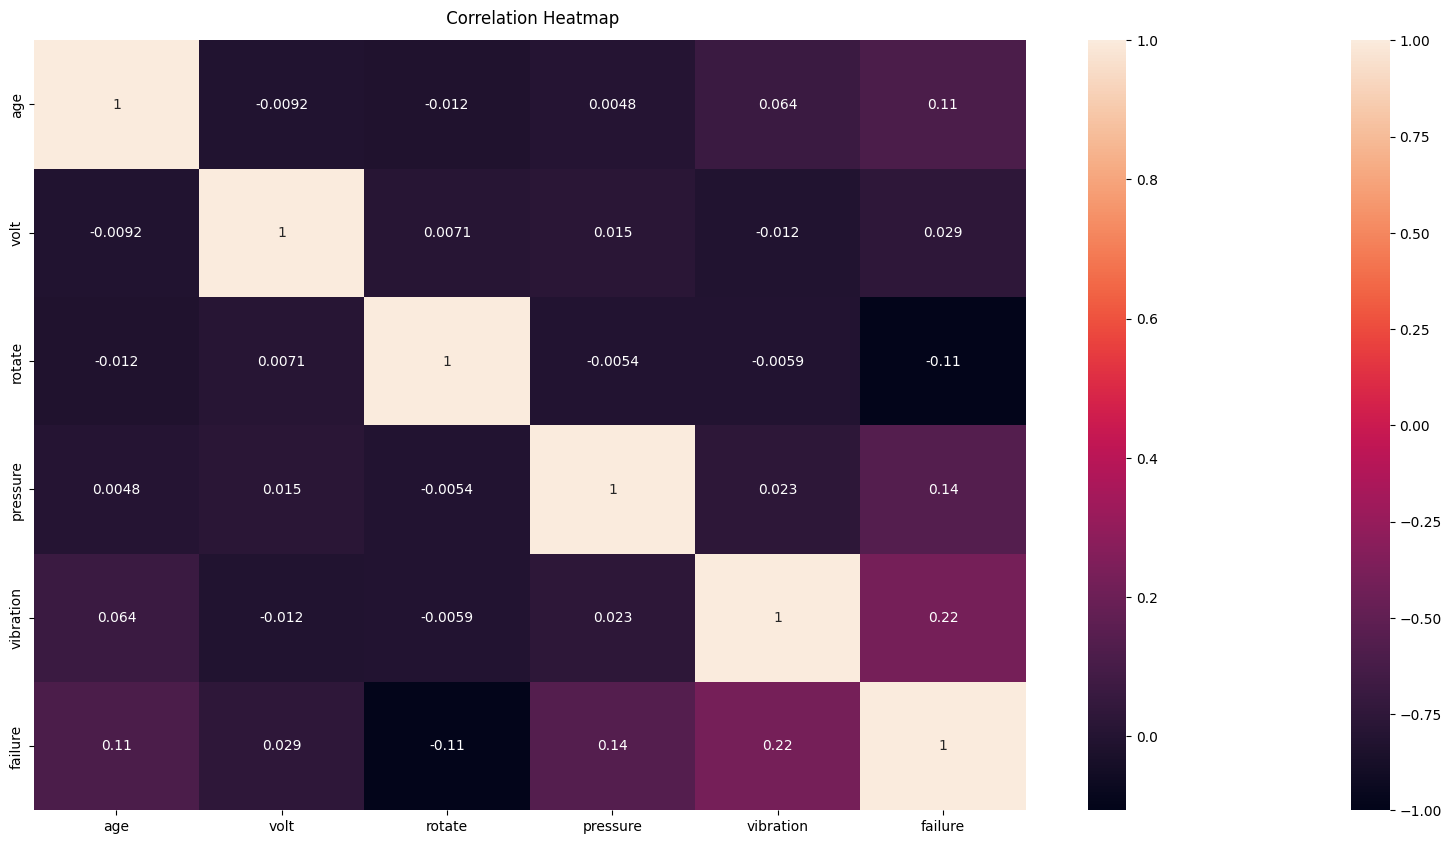

In [90]:
plt.figure(figsize=(20, 10))

heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title(' Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

sns.heatmap(data.corr());

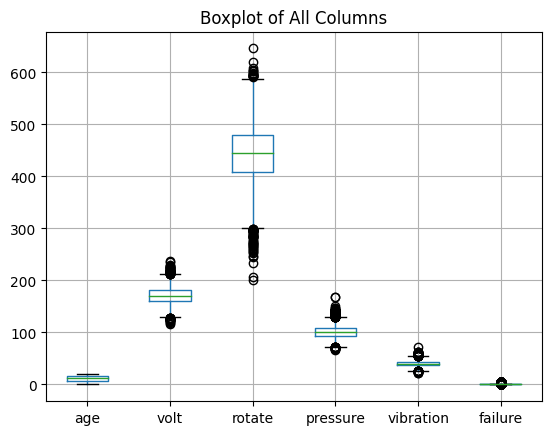

In [27]:
# Create a boxplot of all columns in the DataFrame
data.boxplot()

# Set the title for the plot
plt.title("Boxplot of All Columns")

# Display the plot
plt.show()

In [21]:
#MODELİN KURULMASI ÖNCE MODELİN TRAİN VE TEST DATALARI OLUŞTURULDU SONRASINDA AŞAĞIDAKİ MODELLER SIRASIYLA DENENDİ
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

array([[1.00000000e+00, 1.40000000e+01, 1.76174472e+02, ...,
        1.08147398e+04, 5.04181830e+03, 2.35048945e+03],
       [1.00000000e+00, 1.00000000e+01, 1.52902866e+02, ...,
        1.05634542e+04, 3.48851608e+03, 1.15206108e+03],
       [1.00000000e+00, 1.00000000e+01, 1.38587479e+02, ...,
        5.88587724e+03, 2.41021946e+03, 9.86965512e+02],
       ...,
       [1.00000000e+00, 1.00000000e+00, 1.63372438e+02, ...,
        9.52516325e+03, 4.23536984e+03, 1.88325986e+03],
       [1.00000000e+00, 1.60000000e+01, 1.54147747e+02, ...,
        1.86194745e+04, 5.63406972e+03, 1.70481404e+03],
       [1.00000000e+00, 5.00000000e+00, 1.73575957e+02, ...,
        1.09494809e+04, 5.33073566e+03, 2.59525935e+03]])

In [22]:
y_train

176671    comp0
81005     comp0
664285    comp0
191955    comp0
662346    comp0
          ...  
657792    comp0
123117    comp2
240525    comp2
316211    comp3
507238    comp0
Name: failure, Length: 4462, dtype: object

# Classifiers

In [23]:
# Define the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

# Cross Validation

In [24]:
for name, classifier in classifiers.items():

	model = classifier

	# Apply cross-validation
	cv_scores = cross_val_score(model, X, y, cv=5)

	# Print the cross-validation scores
	print("Model: ", name)
	print("Cross-Validation Scores:", cv_scores)
	print("Mean CV Accuracy:", cv_scores.mean())

Model:  Random Forest
Cross-Validation Scores: [0.890681   0.88978495 0.88978495 0.89147982 0.89237668]
Mean CV Accuracy: 0.8908214796598999
Model:  SVM
Cross-Validation Scores: [0.89605735 0.89605735 0.89605735 0.89686099 0.89686099]
Mean CV Accuracy: 0.8963788032209846
Model:  Logistic Regression
Cross-Validation Scores: [0.89426523 0.89157706 0.89157706 0.89596413 0.89596413]
Mean CV Accuracy: 0.8938695211919573
Model:  Decision Tree
Cross-Validation Scores: [0.82795699 0.81003584 0.84139785 0.82331839 0.83946188]
Mean CV Accuracy: 0.828434190012376
Model:  KNN
Cross-Validation Scores: [0.890681   0.89157706 0.89336918 0.89058296 0.89327354]
Mean CV Accuracy: 0.8918967484771043


In [25]:
# Apply normalization using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# Evaluate each classifier
for name, classifier in classifiers.items():
    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"\n{name} Confusion Matrix:")
    print(conf_matrix)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy:", accuracy)

    # Precision
    precision = precision_score(y_test, y_pred, average='weighted')
    print(f"{name} Precision:", precision)

    # Recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"{name} Recall:", recall)

    # F1 Score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} F1 Score:", f1)




Random Forest Confusion Matrix:
[[999   0   1   1   4]
 [ 27   0   0   3   2]
 [ 31   0   0   2   2]
 [ 14   0   2   1   0]
 [ 20   1   3   1   2]]
Random Forest Accuracy: 0.8978494623655914
Random Forest Precision: 0.8313414536990495
Random Forest Recall: 0.8978494623655914
Random Forest F1 Score: 0.8622665009875674

SVM Confusion Matrix:
[[1005    0    0    0    0]
 [  32    0    0    0    0]
 [  35    0    0    0    0]
 [  17    0    0    0    0]
 [  27    0    0    0    0]]
SVM Accuracy: 0.9005376344086021
SVM Precision: 0.8109680309862412
SVM Recall: 0.9005376344086021
SVM F1 Score: 0.8534090736262567

Logistic Regression Confusion Matrix:
[[997   0   2   1   5]
 [ 29   0   0   2   1]
 [ 34   0   1   0   0]
 [ 15   0   0   2   0]
 [ 24   0   0   1   2]]
Logistic Regression Accuracy: 0.8978494623655914
Logistic Regression Precision: 0.8385373012068101
Logistic Regression Recall: 0.8978494623655914
Logistic Regression F1 Score: 0.8605211161492862

Decision Tree Confusion Matrix:
[[

In [29]:
import time


In [30]:
# Train and evaluate each classifier
results = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    start_time = time.time()  # Başlangıç zamanını kaydet
    y_pred = classifier.predict(X_test)
    end_time = time.time()  # Bitiş zamanını kaydet
    total_time = (end_time - start_time) * 1000  # Süreyi milisaniyeye dönüştür
    print("Fonksiyon süresi: {} ms".format(total_time))
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy}")

Fonksiyon süresi: 19.38462257385254 ms
Random Forest Accuracy: 0.899641577060932
Fonksiyon süresi: 68.93301010131836 ms
SVM Accuracy: 0.9005376344086021
Fonksiyon süresi: 0.2655982971191406 ms
Logistic Regression Accuracy: 0.8978494623655914
Fonksiyon süresi: 0.4088878631591797 ms
Decision Tree Accuracy: 0.8405017921146953
Fonksiyon süresi: 35.7210636138916 ms
KNN Accuracy: 0.9014336917562724


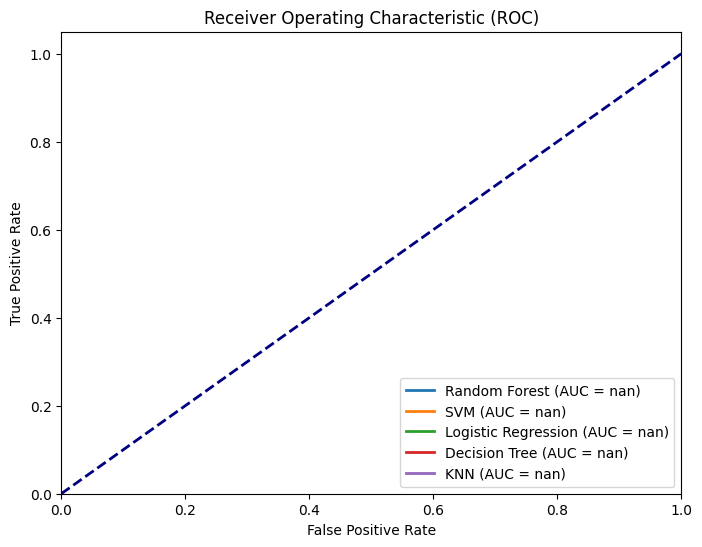

In [36]:
# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))
for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

In [103]:
# Print the accuracy results
print("\nAccuracy Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy}")


Accuracy Results:
Random Forest: 0.8969534050179212
SVM: 0.9005376344086021
Logistic Regression: 0.8978494623655914
Decision Tree: 0.8360215053763441
KNN: 0.9014336917562724


# ANN

In [26]:
# Create a neural network model
model2 = Sequential()

model2.add(Dense(16, input_dim=X_train.shape[1], activation='relu'))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(5))

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [27]:
# Train the model
history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


2023-06-21 08:48:13.199781: W tensorflow/core/framework/op_kernel.cc:1807] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast string to int64 is not supported


UnimplementedError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/Cast' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/bulut/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/bulut/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/bulut/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/bulut/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5425/1687652183.py", line 2, in <module>
      history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/losses.py", line 2078, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/backend.py", line 5610, in sparse_categorical_crossentropy
      target = cast(target, "int64")
    File "/home/bulut/.local/lib/python3.10/site-packages/keras/backend.py", line 2304, in cast
      return tf.cast(x, dtype)
Node: 'sparse_categorical_crossentropy/Cast'
Cast string to int64 is not supported
	 [[{{node sparse_categorical_crossentropy/Cast}}]] [Op:__inference_train_function_2005]

In [137]:
# Evaluate the model
_, accuracy = model2.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

35/35 [==============================] - 0s 1ms/step - loss: 0.9957 - accuracy: 0.9005
Accuracy: 0.9005376100540161


In [78]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 32)                704       
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_53 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_54 (Dense)            (None, 16)                528       
                                                                 
 dense_55 (Dense)            (None, 5)               

In [116]:
# Make predictions on new data
new_data = pd.DataFrame([[6,187.489605241079,443.209039429435,101.054716550381,33.7022811824653]], columns=["age", "volt", "rotate", "pressure", "vibration"])

In [117]:
predictions = model.predict(new_data)

In [ ]:
model1.save('model1.h5')

In [118]:
predictions

array([0])

In [119]:
# Convert the predicted labels back to their original categorical values
predicted_failure = label_encoder.inverse_transform(predictions)

In [120]:
predicted_failure

array(['comp0'], dtype=object)

In [ ]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

In [16]:
for m in ("linear", "poly", "rbf", "sigmoid"):
    clf = SVC(C=1, kernel=m, degree=5, decision_function_shape="ovr")
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    print(f"\n{m.title()} SVC:")
    print("Accuracy: ", metrics.accuracy_score(test_y, pred_y))
    print("Precision: ", metrics.precision_score(test_y, pred_y, average="macro"))
    print("Recall: ", metrics.recall_score(test_y, pred_y, average="macro"))
    del clf
for m in ("newton-cg", "sag", "saga", "lbfgs"):
    clf = LogisticRegression(random_state=2, multi_class='multinomial', penalty='l2', solver=m)
    clf.fit(train_X, train_y)
    pred_y = clf.predict(test_X)
    print(f"\n{m.title()} LR:")
    print("Accuracy: ", metrics.accuracy_score(test_y, pred_y))
    print("Precision: ", metrics.precision_score(test_y, pred_y, average="macro"))
    print("Recall: ", metrics.recall_score(test_y, pred_y, average="macro"))
    del clf
clf = GaussianNB()
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
print("\nGaussian:")
print("Accuracy: ", metrics.accuracy_score(test_y, pred_y))
print("Precision: ", metrics.precision_score(test_y, pred_y, average="macro"))
print("Recall: ", metrics.recall_score(test_y, pred_y, average="macro"))
del clf


Linear SVC:
Accuracy:  0.8951612903225806
Precision:  0.17903225806451611
Recall:  0.2

Poly SVC:
Accuracy:  0.8951612903225806
Precision:  0.17903225806451611
Recall:  0.2

Rbf SVC:
Accuracy:  0.8951612903225806
Precision:  0.17903225806451611
Recall:  0.2

Sigmoid SVC:
Accuracy:  0.8906810035842294
Precision:  0.17893789378937894
Recall:  0.198998998998999

Newton-Cg LR:
Accuracy:  0.8960573476702509
Precision:  0.39421338155515373
Recall:  0.2383658658658659

Sag LR:
Accuracy:  0.8915770609318996
Precision:  0.21926059513074841
Recall:  0.2056656656656657

Saga LR:
Accuracy:  0.8933691756272402
Precision:  0.24596459645964597
Recall:  0.2060660660660661

Lbfgs LR:
Accuracy:  0.8924731182795699
Precision:  0.22927927927927927
Recall:  0.20586586586586586

Gaussian:
Accuracy:  0.8978494623655914
Precision:  0.4097242190563325
Recall:  0.30153153153153156


In [17]:
clf_GNB = GaussianNB()
clf_GNB.fit(train_X, train_y)
pred_y = clf_GNB.predict(test_X)
print("\n[EN BAŞARILI ] Gaussian Model:")
print("Accuracy: ", metrics.accuracy_score(test_y, pred_y))
print("Precision: ", metrics.precision_score(test_y, pred_y, average="macro"))
print("Recall: ", metrics.recall_score(test_y, pred_y, average="macro"))


[EN BAŞARILI ] Gaussian Model:
Accuracy:  0.8978494623655914
Precision:  0.4097242190563325
Recall:  0.30153153153153156


In [18]:
data_2.to_csv("data_2.csv") 

In [19]:
data_2 = pd.read_csv("data_2.csv") 
data_2 = data_2.iloc[:, 1:-1]
data_2

,age,volt,rotate,pressure,vibration
0,6,187.489605,443.209039,101.054717,33.702281
1,6,151.114448,303.530318,77.519149,29.228292
2,6,161.755642,342.792271,97.993523,46.982916
3,6,174.405920,348.570676,103.267420,43.415957
4,6,167.672600,349.965886,93.760930,43.991618
...,...,...,...,...,...
183986,5,179.438162,395.222827,102.290715,50.771941
183987,5,189.617555,446.207972,98.180607,35.123072
183988,5,192.483414,447.816524,94.132837,48.314561
183989,5,165.475310,413.771670,104.081073,44.835259


In [54]:
deneme4 = data_2 = pd.read_csv("deneme.csv") 
deneme4
deneme4 = deneme4[["5","177.033599091313","413.074823291794","120.788323442381","49.0154152788145"]]
deneme4
deneme4.to_csv("deneme4.csv")

In [39]:
data_3 = data_2[:10000]

In [40]:
data_3.to_csv("data_3.csv")

In [20]:

EXT = open(r'data\dataexcluded', 'wb')
pickle.dump(data_excluded, EXT)
EXT.close()



secondmodel = open(r'data\secondmodel', 'wb')
pickle.dump(clf_GNB, secondmodel)
secondmodel.close()

In [21]:

EXT = open(r'data\dataexcluded', 'rb')
data = pickle.load(EXT)
EXT.close()




secondmodel = open(r'data\secondmodel', 'rb')
clf2 = pickle.load(secondmodel)
secondmodel.close()

In [22]:
#MODELİN TAHMİN AMACIYLA ÇALIŞTIRILMASI
"""SADECE İNPUT DEĞİŞTİRİLECEK"""

data = pd.read_csv(r"data_2.csv")
for X in range(data.shape[0]):
    
    print(clf2.predict(data.iloc[X, 1:].values.reshape(1,-1)))
#for X in range(data.shape[0]):
#    print(clf2.predict(data.iloc[X, :-1].values.reshape(1,-1)))

ValueError: could not convert string to float: 'comp0'

In [ ]:
data = pd.read_csv(r"deneme.csv")
for X in range(data.shape[0]):
    print(clf2.predict(data.iloc[X, 1:-1].values.reshape(1,-1)))
#for X in range(data.shape[0]):
#    print(clf2.predict(data.iloc[X, :-1].values.reshape(1,-1)))